In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import copy
import pyepo
import torch
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)
from sklearn.model_selection import train_test_split

Auto-Sklearn cannot be imported.


In [3]:
# linear model
class LinearRegression(nn.Module):
    
    def __init__(self, indim, outdim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(indim, outdim)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [4]:
def train_h(optmodel, reg, trainloader, testloader, lr, num_epochs=300, lambd=20):
    # cuda
    if torch.cuda.is_available():
        reg = reg.cuda()
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set dbb optimizer
    dbb = pyepo.func.blackboxOpt(optmodel, lambd=lambd, processes=4)
    # set loss
    criterion = nn.L1Loss()
    # train model
    reg.train()
    loss_log = []
    grad_log = []
    regret = pyepo.metric.regret(reg, optmodel, testloader)
    regret_log = [regret]
    print("Epoch   0, Loss: Unknown, Regret: {:7.4f}%".format(regret*100))
    for epoch in range(num_epochs):
        # load data
        for i, data in enumerate(trainloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = reg(x)
            # black-box optimizer
            wp = dbb(cp)
            # loss
            loss = criterion(wp, w)
            # add hook
            abs_grad = []
            cp.register_hook(lambda grad: abs_grad.append(torch.abs(grad).mean().item()))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # add log
            loss_log.append(loss.item())
            grad_log.append(abs_grad[0])
        if epoch % 5 == 0:
            # true regret
            regret = pyepo.metric.regret(reg, optmodel, testloader)
            regret_log.append(regret)
            print("Epoch {:3}, Loss: {:7.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
    drawplot(num_epochs, grad_log, loss_log)
    return regret_log

In [5]:
def train_r(optmodel, reg, trainloader, testloader, lr, num_epochs=300, lambd=20):
    # cuda
    if torch.cuda.is_available():
        reg = reg.cuda()
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set dbb optimizer
    dbb = pyepo.func.blackboxOpt(optmodel, lambd=lambd, processes=4)
    # set loss
    criterion = nn.L1Loss()
    # train model
    reg.train()
    regret = pyepo.metric.regret(reg, optmodel, testloader)
    regret_log = [regret]
    print("Epoch   0, Loss: Unknown, Regret: {:7.4f}%".format(regret*100))
    for epoch in range(num_epochs):
        # load data
        for i, data in enumerate(trainloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = reg(x)
            # black-box optimizer
            wp = dbb(cp)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # loss
            loss = criterion(zp, z)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 5 == 0:
            # true regret
            regret = pyepo.metric.regret(reg, optmodel, testloader)
            regret_log.append(regret)
            print("Epoch {:3}, Loss: {:7.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
    return regret_log

In [6]:
def drawplot(num_epochs, grad_log, loss_log):
    # loss
    fig = plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve", fontsize=36)
    plt.show()
    # abs grad
    fig = plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Learning Curve", fontsize=36)
    plt.show()

## Shortest Path

In [7]:
# init data
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise half-width
x, c = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e)

In [8]:
# optimization model 
sp_model = pyepo.model.grb.shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-09


In [9]:
# prediction model
reg = LinearRegression(p, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

In [10]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)
sp_dataset_train = pyepo.data.dataset.optDataset(sp_model, x_train, c_train)
sp_dataset_test = pyepo.data.dataset.optDataset(sp_model, x_test, c_test)
# data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1138.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1114.60it/s]


Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 52.0637%
Epoch   0, Loss:  0.2875, Regret: 44.2693%
Epoch   5, Loss:  0.2562, Regret: 34.0913%
Epoch  10, Loss:  0.2375, Regret: 27.1244%
Epoch  15, Loss:  0.1562, Regret: 18.6017%
Epoch  20, Loss:  0.0625, Regret: 12.8788%
Epoch  25, Loss:  0.1063, Regret: 13.2347%
Epoch  30, Loss:  0.1500, Regret: 13.2056%
Epoch  35, Loss:  0.1875, Regret: 11.8401%
Epoch  40, Loss:  0.1750, Regret: 11.8953%
Epoch  45, Loss:  0.1313, Regret: 12.3999%
Epoch  50, Loss:  0.1437, Regret: 11.7551%
Epoch  55, Loss:  0.1375, Regret: 12.2952%
Epoch  60, Loss:  0.1938, Regret: 12.2958%
Epoch  65, Loss:  0.0938, Regret: 12.0925%
Epoch  70, Loss:  0.1625, Regret: 11.4865%
Epoch  75, Loss:  0.1375, Regret: 11.9286%
Epoch  80, Loss:  0.1750, Regret: 12.0982%
Epoch  85, Loss:  0.1375, Regret: 12.0429%
Epoch  90, Loss:  0.1500, Regret: 11.1184%
Epoch  95, Loss:  0.1750, Regret: 12.2058%
Epoch 100, Loss:  0.2313, Regret: 12.0642%
Epoch 105, Loss:  0.1437, Regret: 11.8

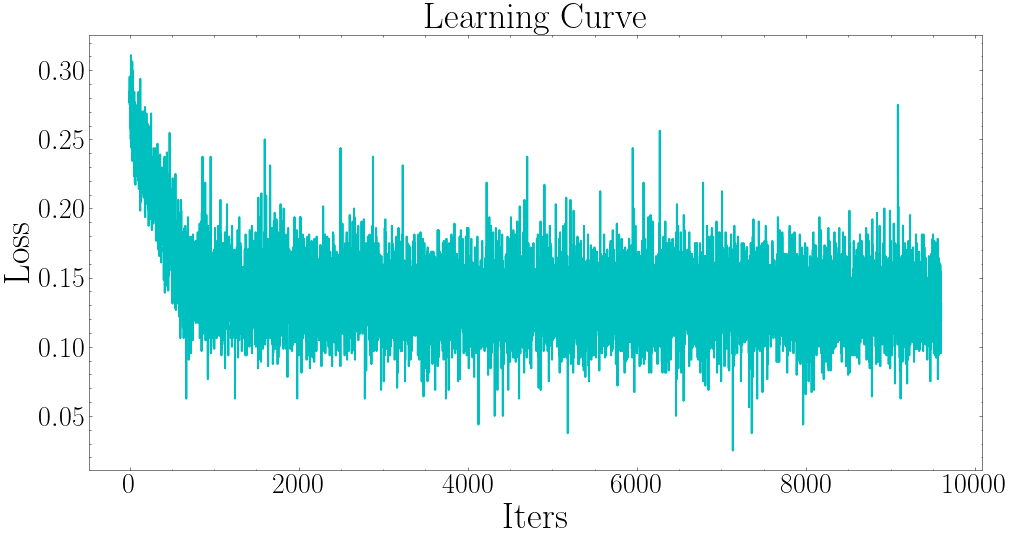

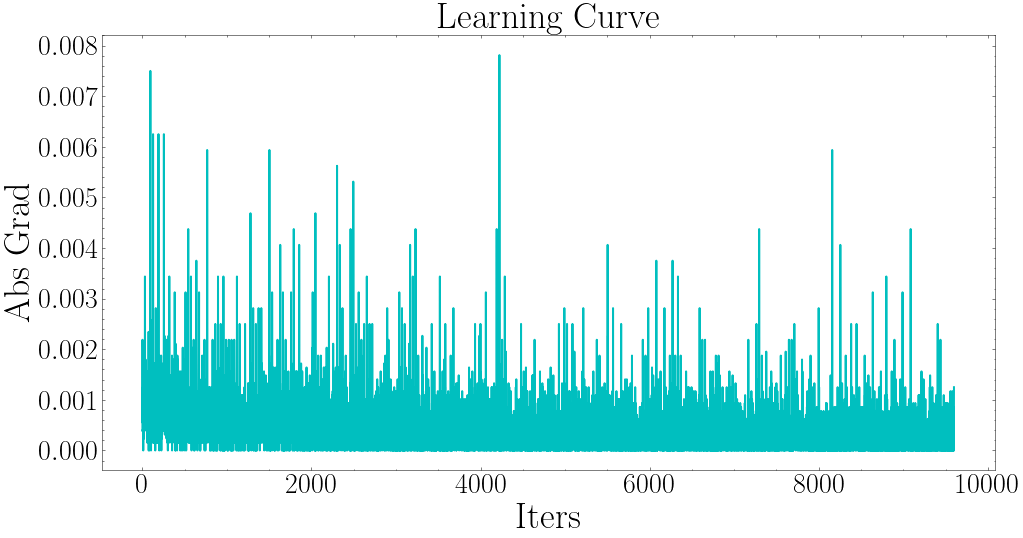

In [11]:
# train
loss_h = train_h(sp_model, copy.deepcopy(reg), sp_loader_train, sp_loader_test, lr=5e-3)

In [12]:
# train
loss_r = train_r(sp_model, copy.deepcopy(reg), sp_loader_train, sp_loader_test, lr=5e-3)

Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 52.0637%
Epoch   0, Loss:  0.6997, Regret: 33.9711%
Epoch   5, Loss:  0.8015, Regret: 11.3125%
Epoch  10, Loss:  0.9230, Regret: 12.0384%
Epoch  15, Loss:  0.2301, Regret: 15.5931%
Epoch  20, Loss:  0.7510, Regret: 16.2449%
Epoch  25, Loss:  0.6744, Regret: 19.5981%
Epoch  30, Loss:  0.5233, Regret: 15.8446%
Epoch  35, Loss:  0.2912, Regret: 14.3174%
Epoch  40, Loss:  0.3006, Regret: 16.4950%
Epoch  45, Loss:  0.2989, Regret: 17.2524%
Epoch  50, Loss:  1.0403, Regret: 24.3184%
Epoch  55, Loss:  0.6169, Regret: 19.7185%
Epoch  60, Loss:  0.5108, Regret: 16.3984%
Epoch  65, Loss:  0.4933, Regret: 15.5196%
Epoch  70, Loss:  0.6117, Regret: 16.7402%
Epoch  75, Loss:  0.8042, Regret: 18.4721%
Epoch  80, Loss:  1.1309, Regret: 13.4359%
Epoch  85, Loss:  0.1906, Regret: 13.7791%
Epoch  90, Loss:  0.9428, Regret: 20.4486%
Epoch  95, Loss:  0.3947, Regret: 16.4070%
Epoch 100, Loss:  0.7980, Regret: 19.7700%
Epoch 105, Loss:  0.1256, Regret: 16.1

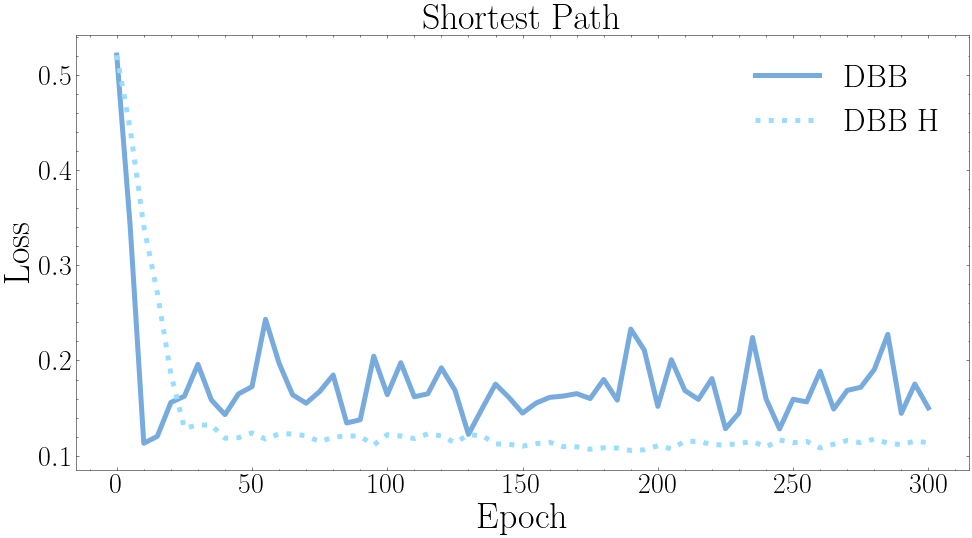

In [13]:
# color map
cset =  tc.tol_cset('light')
colors = [cset.light_blue, cset.light_cyan]
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, 305, 5), loss_r, color=cset.light_blue, ls="-", lw=5, label="DBB")
plt.plot(range(0, 305, 5), loss_h, color=cset.light_cyan, ls=":", lw=5, label="DBB H")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Shortest Path", fontsize=36)
plt.legend(fontsize=32)
plt.show()
#fig.savefig("./images/hamming-sp.pdf", dpi=300)

## 2D Knapsack

In [14]:
# init data
m = 48 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [30] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [15]:
# optimization model 
ks_model = pyepo.model.grb.knapsackModel(weights, caps)

In [16]:
# prediction model
reg = LinearRegression(p, m)

In [17]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)
# data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.97it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.91it/s]


Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 52.6396%
Epoch   0, Loss:  0.2292, Regret: 52.6396%
Epoch   5, Loss:  0.1927, Regret: 52.6396%
Epoch  10, Loss:  0.1979, Regret: 52.6396%
Epoch  15, Loss:  0.2500, Regret: 52.6396%
Epoch  20, Loss:  0.2188, Regret: 52.6396%
Epoch  25, Loss:  0.1875, Regret: 52.6396%
Epoch  30, Loss:  0.2083, Regret: 52.6396%
Epoch  35, Loss:  0.2135, Regret: 52.6396%
Epoch  40, Loss:  0.2135, Regret: 52.6396%
Epoch  45, Loss:  0.2083, Regret: 52.6396%
Epoch  50, Loss:  0.2083, Regret: 52.6396%
Epoch  55, Loss:  0.2083, Regret: 52.6396%
Epoch  60, Loss:  0.2188, Regret: 52.6396%
Epoch  65, Loss:  0.2135, Regret: 52.6396%
Epoch  70, Loss:  0.2135, Regret: 52.6396%
Epoch  75, Loss:  0.2031, Regret: 52.6396%
Epoch  80, Loss:  0.2240, Regret: 52.6396%
Epoch  85, Loss:  0.2031, Regret: 52.6396%
Epoch  90, Loss:  0.2083, Regret: 52.6396%
Epoch  95, Loss:  0.2031, Regret: 52.6396%
Epoch 100, Loss:  0.2083, Regret: 52.6396%
Epoch 105, Loss:  0.1875, Regret: 52.6

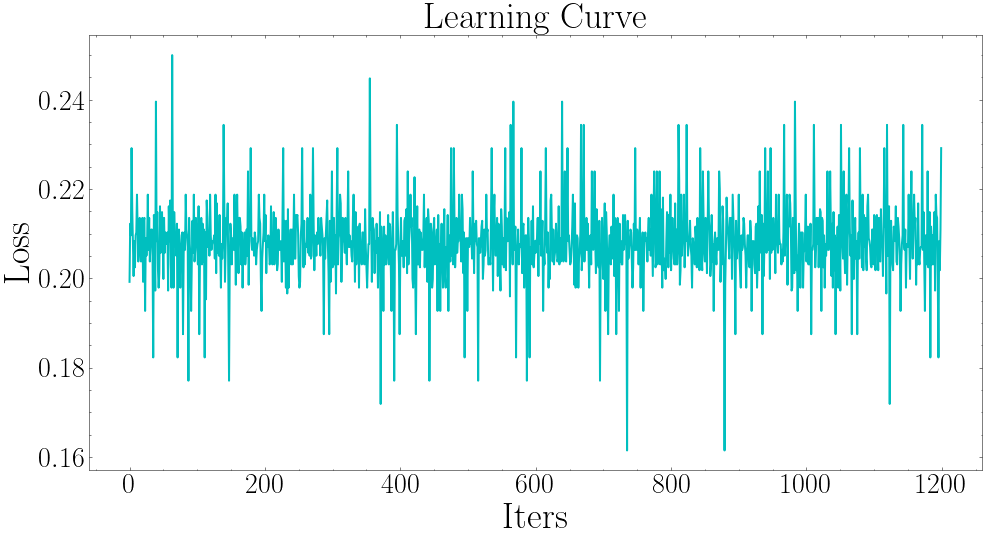

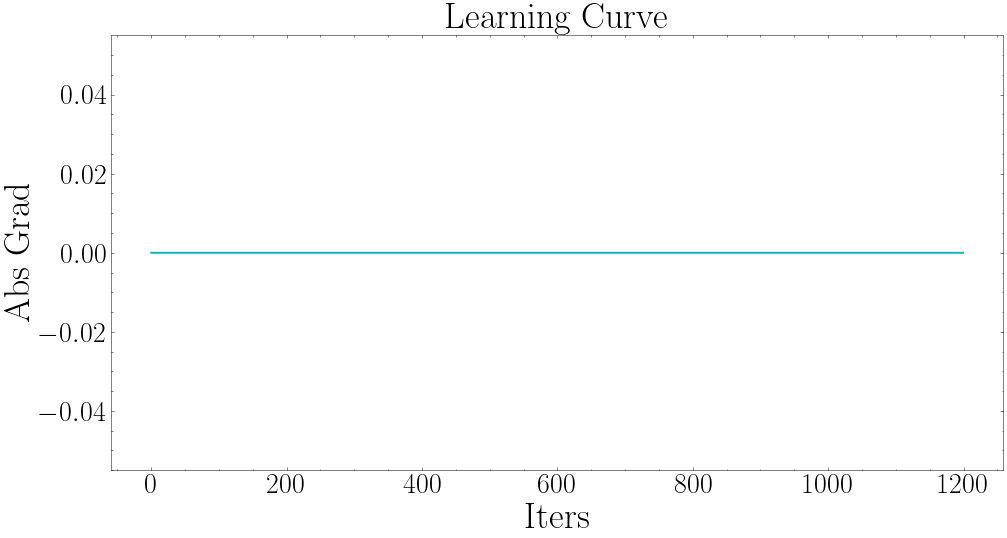

In [18]:
# train
loss_h = train_h(ks_model, copy.deepcopy(reg), ks_loader_train, ks_loader_test, lr=5e-2)

In [19]:
# train
loss_r = train_r(ks_model, copy.deepcopy(reg), ks_loader_train, ks_loader_test, lr=5e-2)

Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 52.6396%
Epoch   0, Loss: 42.0000, Regret: 48.2332%
Epoch   5, Loss: 37.5000, Regret: 37.8205%
Epoch  10, Loss: 31.2500, Regret: 31.3817%
Epoch  15, Loss: 10.5000, Regret: 26.9754%
Epoch  20, Loss: 15.7500, Regret: 24.4197%
Epoch  25, Loss:  8.7500, Regret: 23.5267%
Epoch  30, Loss:  8.0000, Regret: 22.1670%
Epoch  35, Loss:  4.0000, Regret: 21.2154%
Epoch  40, Loss:  8.7500, Regret: 20.7790%
Epoch  45, Loss:  7.2500, Regret: 20.4517%
Epoch  50, Loss:  6.0000, Regret: 20.5063%
Epoch  55, Loss: 17.7500, Regret: 20.3730%
Epoch  60, Loss: 14.0000, Regret: 20.3043%
Epoch  65, Loss:  5.7500, Regret: 20.1729%
Epoch  70, Loss:  3.7500, Regret: 20.0517%
Epoch  75, Loss: 14.0000, Regret: 20.0335%
Epoch  80, Loss:  4.7500, Regret: 20.1224%
Epoch  85, Loss:  8.2500, Regret: 20.1022%
Epoch  90, Loss:  4.2500, Regret: 20.2032%
Epoch  95, Loss: 11.0000, Regret: 20.1871%
Epoch 100, Loss: 13.2500, Regret: 20.1871%
Epoch 105, Loss:  3.7500, Regret: 20.2

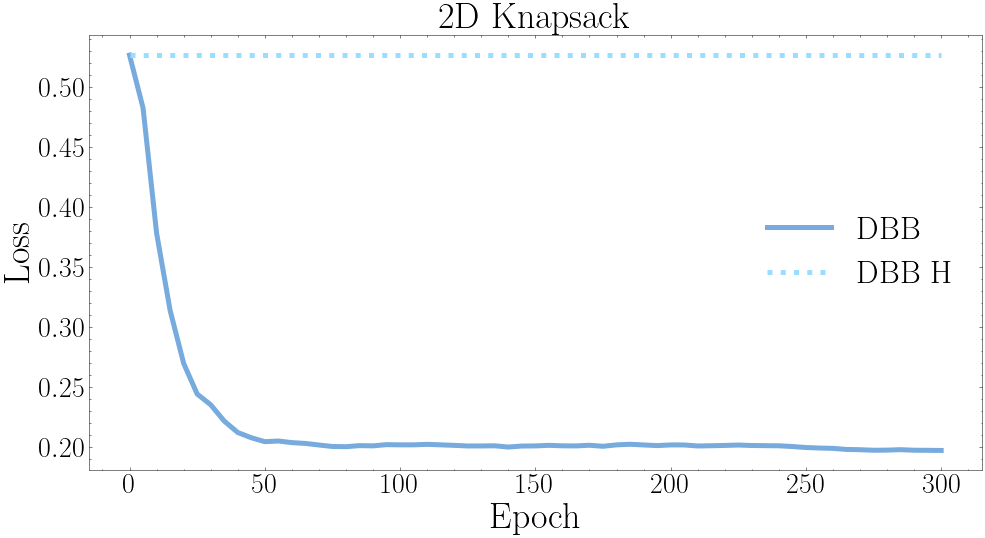

In [20]:
# color map
cset =  tc.tol_cset('light')
colors = [cset.light_blue, cset.light_cyan]
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, 305, 5), loss_r, color=cset.light_blue, ls="-", lw=5, label="DBB")
plt.plot(range(0, 305, 5), loss_h, color=cset.light_cyan, ls=":", lw=5, label="DBB H")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("2D Knapsack", fontsize=36)
plt.legend(fontsize=32)
plt.show()
#fig.savefig("./images/hamming-ks2.pdf", dpi=300)

## TSP 

In [21]:
# init data
m = 20 # number of nodes
n = 1000 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise half-width
x, c = pyepo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=e)

In [22]:
# optimization model 
tsp_model = pyepo.model.grb.tspDFJModel(m)

In [23]:
# prediction model
reg = LinearRegression(p, m*(m-1)//2)

In [24]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=600, random_state=246)
tsp_dataset_train = pyepo.data.dataset.optDataset(tsp_model, x_train, c_train)
tsp_dataset_test = pyepo.data.dataset.optDataset(tsp_model, x_test, c_test)
# data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:09<00:00, 145.26it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 143.04it/s]


Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 181.6178%
Epoch   0, Loss:  0.1833, Regret: 164.0022%
Epoch   5, Loss:  0.1873, Regret: 165.5420%
Epoch  10, Loss:  0.1895, Regret: 162.6855%
Epoch  15, Loss:  0.1877, Regret: 160.3921%
Epoch  20, Loss:  0.1873, Regret: 158.2133%
Epoch  25, Loss:  0.1763, Regret: 160.1772%
Epoch  30, Loss:  0.1772, Regret: 157.8676%
Epoch  35, Loss:  0.1789, Regret: 157.7276%
Epoch  40, Loss:  0.1794, Regret: 155.3632%
Epoch  45, Loss:  0.1759, Regret: 153.8568%
Epoch  50, Loss:  0.1776, Regret: 156.6863%
Epoch  55, Loss:  0.1737, Regret: 150.5375%
Epoch  60, Loss:  0.1768, Regret: 147.6182%
Epoch  65, Loss:  0.1680, Regret: 144.6373%
Epoch  70, Loss:  0.1746, Regret: 145.6129%
Epoch  75, Loss:  0.1759, Regret: 145.3970%
Epoch  80, Loss:  0.1746, Regret: 145.8323%
Epoch  85, Loss:  0.1772, Regret: 146.0741%
Epoch  90, Loss:  0.1811, Regret: 145.2408%
Epoch  95, Loss:  0.1719, Regret: 141.8135%
Epoch 100, Loss:  0.1737, Regret: 141.0932%
Epoch 105, Loss:

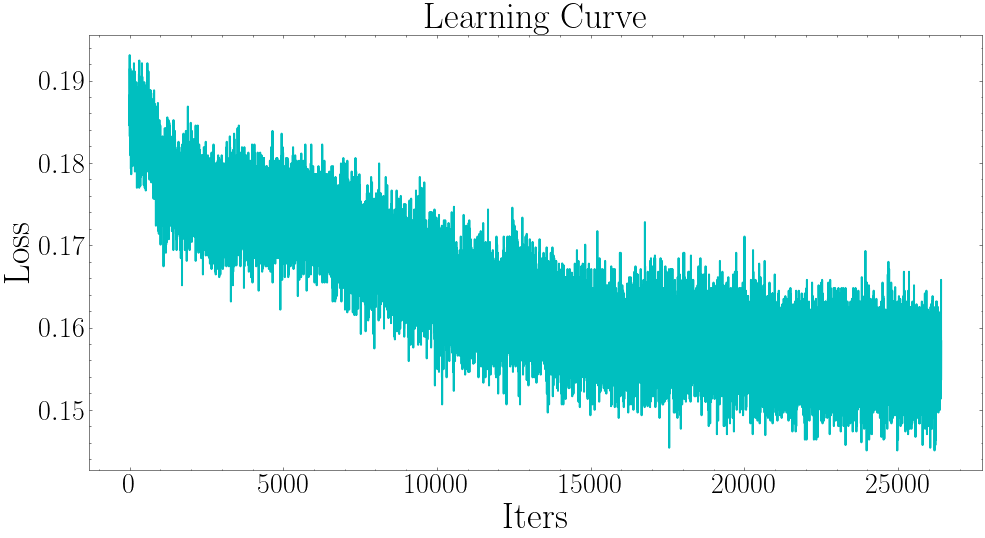

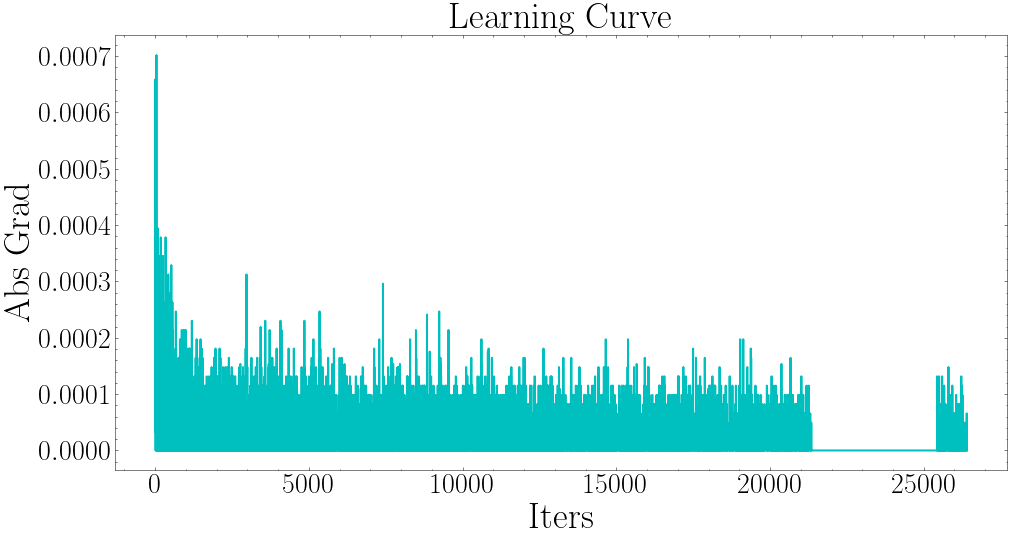

In [25]:
# train
loss_h = train_h(tsp_model, copy.deepcopy(reg), tsp_loader_train, tsp_loader_test, num_epochs=600, lr=5e-2)

In [26]:
# train
loss_r = train_r(tsp_model, copy.deepcopy(reg), tsp_loader_train, tsp_loader_test, lr=5e-2)

Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 181.6178%
Epoch   0, Loss:  5.4338, Regret: 11.4278%
Epoch   5, Loss:  4.1982, Regret:  9.2682%
Epoch  10, Loss:  4.0214, Regret:  9.0946%
Epoch  15, Loss:  3.9922, Regret:  8.1737%
Epoch  20, Loss:  3.3611, Regret:  7.6623%
Epoch  25, Loss:  3.7383, Regret:  7.8791%
Epoch  30, Loss:  3.9864, Regret:  7.3279%
Epoch  35, Loss:  2.4861, Regret:  7.3153%
Epoch  40, Loss:  2.6958, Regret:  7.1222%
Epoch  45, Loss:  2.4602, Regret:  7.0247%
Epoch  50, Loss:  3.5002, Regret:  7.1084%
Epoch  55, Loss:  2.6328, Regret:  7.1327%
Epoch  60, Loss:  2.4975, Regret:  7.3847%
Epoch  65, Loss:  2.4902, Regret:  7.4468%
Epoch  70, Loss:  2.7420, Regret:  7.1634%
Epoch  75, Loss:  2.6363, Regret:  7.0620%
Epoch  80, Loss:  2.7686, Regret:  7.0847%
Epoch  85, Loss:  2.5521, Regret:  7.1598%
Epoch  90, Loss:  2.2438, Regret:  7.3222%
Epoch  95, Loss:  2.5132, Regret:  6.9432%
Epoch 100, Loss:  2.5836, Regret:  7.0044%
Epoch 105, Loss:  1.9655, Regret:  7.

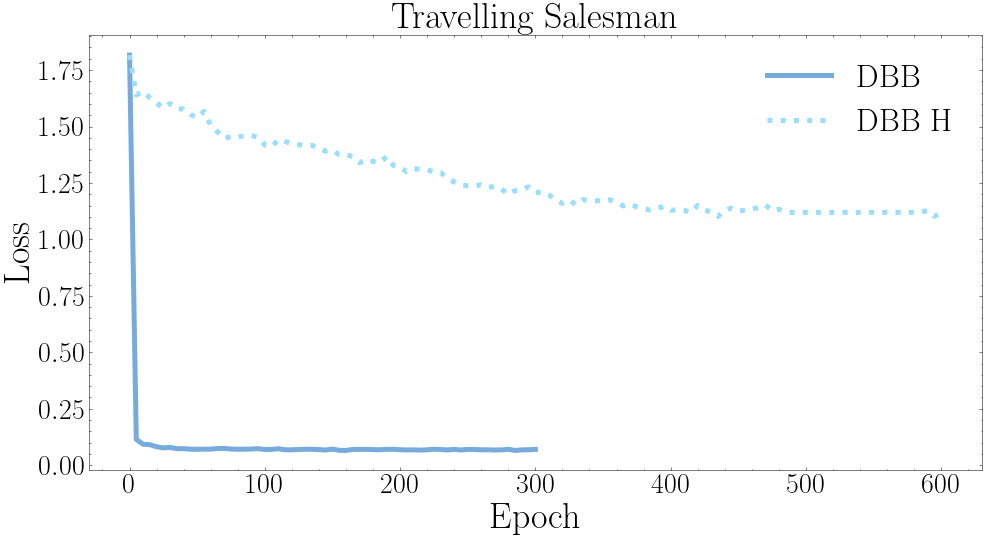

In [27]:
# color map
cset =  tc.tol_cset('light')
colors = [cset.light_blue, cset.light_cyan]
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, 305, 5), loss_r, color=cset.light_blue, ls="-", lw=5, label="DBB")
plt.plot(range(0, 605, 5), loss_h, color=cset.light_cyan, ls=":", lw=5, label="DBB H")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Travelling Salesman", fontsize=36)
plt.legend(fontsize=32)
plt.show()
#fig.savefig("./images/hamming-tsp.pdf", dpi=300)